<a href="https://colab.research.google.com/github/DileepGunithi/Calculator/blob/main/Copy_of_Brain_Tumor_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.layers import Input # import the Input layer
from IPython import get_ipython
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
from PIL import Image, ImageEnhance
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from sklearn.utils import shuffle

**Load Datasets**

In [ ]:
train_dir = '/content/drive/MyDrive/Training'
test_dir = '/content/drive/MyDrive/Testing'

# Load and shuffle the train data
train_paths = []
train_labels = []
for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
      train_paths.append(os.path.join(train_dir, label, image))
      train_labels.append(label)
train_paths, train_labels = shuffle(train_paths, train_labels)

# Load and shuffle the test data
test_paths = []
test_labels = []
for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
      test_paths.append(os.path.join(test_dir, label, image))
      test_labels.append(label)
test_paths, test_labels = shuffle(test_paths, test_labels)



train_paths
test_paths

['/content/drive/MyDrive/Testing/no_tumor/image(54).jpg',
 '/content/drive/MyDrive/Testing/pituitary_tumor/image(28).jpg',
 '/content/drive/MyDrive/Testing/meningioma_tumor/image(44).jpg',
 '/content/drive/MyDrive/Testing/glioma_tumor/image(20).jpg',
 '/content/drive/MyDrive/Testing/no_tumor/image(32).jpg',
 '/content/drive/MyDrive/Testing/meningioma_tumor/image(88).jpg',
 '/content/drive/MyDrive/Testing/pituitary_tumor/image(47).jpg',
 '/content/drive/MyDrive/Testing/meningioma_tumor/image(79).jpg',
 '/content/drive/MyDrive/Testing/no_tumor/image(5).jpg',
 '/content/drive/MyDrive/Testing/meningioma_tumor/image(66).jpg',
 '/content/drive/MyDrive/Testing/pituitary_tumor/image(15).jpg',
 '/content/drive/MyDrive/Testing/meningioma_tumor/image(59).jpg',
 '/content/drive/MyDrive/Testing/no_tumor/image(70).jpg',
 '/content/drive/MyDrive/Testing/meningioma_tumor/image(70).jpg',
 '/content/drive/MyDrive/Testing/pituitary_tumor/image(34).jpg',
 '/content/drive/MyDrive/Testing/no_tumor/image(59)

**Data Visualization**

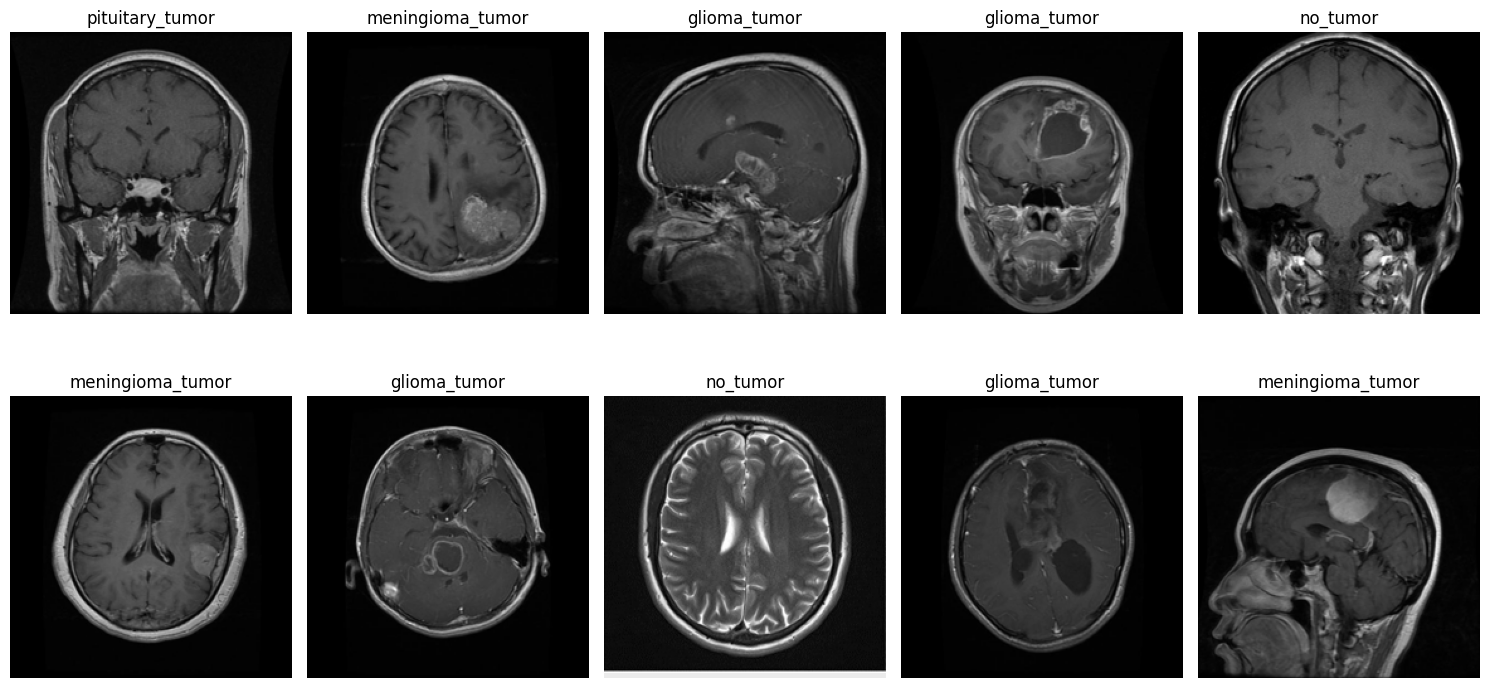

In [ ]:
import random
import matplotlib.pyplot as plt
from PIL import Image
import os

#select random indices for 10 images
random_indices = random.sample(range(len(train_paths)), 10)

# create a figure to display images in 2 rows
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
# Flatten the axes array to iterate through it correctly
axes = axes.ravel() # Assign the output to axes to flatten it

for i, idx in enumerate(random_indices):
   #load the image
   img_path = train_paths[idx]
   img = Image.open(img_path)
   img = img.resize((224, 224))  #resize to consistent size


#Display the image

   axes[i].imshow(img) # Now axes[i] references an Axes object
   axes[i].axis('off')
   axes[i].set_title(train_labels[idx])

plt.tight_layout()
plt.show()

**Image Preprocessing (Helpher Functions)**

In [ ]:
def augement_image(image):
  image = Image.fromarray(np.uint8(image))
  image = ImageEnhance.Brightness(image).enhance(random.uniform(0.8, 1.2))
  image = ImageEnhance.Contrast(image).enhance(random.uniform(0.8, 1.2))
  image = np.array(image)/255.0
  return image



#Load images and apply augmentation
def open_images(paths):
  images = []
  for path in paths:
    # Resize image using IMAGE_SIZE
    image = load_img(path, target_size = (IMAGE_SIZE, IMAGE_SIZE))
    image = augement_image(image)
    # Append the image variable defined in this scope
    images.append(image)
  return np.array(images)



#Encoder labels. (convert label names to integer)
def encode_labels(labels):
  unique_labels = os.listdir(train_dir)
  encoded = [unique_labels.index(label) for label in labels]
  return np.array(encoded)


#Data generator for batching
def data_gen(paths, labels, batch_size = 12, epochs = 1):
  for _ in range(epochs):
    for i in range(0, len(paths), batch_size):
      batch_paths = paths[i:i+batch_size]
      batch_images = open_images(batch_paths)
      batch_labels = labels[i:i+batch_size]
      batch_labels = encode_labels(batch_labels)
      yield batch_images, batch_labels

In [ ]:
len(os.listdir(train_dir))

4

In [ ]:
# model Architecture
IMAGE_SIZE = 128
base_model  = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = 'imagenet')


#freeze all the layers of the VGG16 base model
for layer in base_model.layers:
  layer.trainable = False


# Set only the last few Layers
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True


# Bulid the model
model = Sequential()
model.add(Input(shape =(IMAGE_SIZE, IMAGE_SIZE, 3))) # i/p layer
model.add(base_model)  # VG16 model
model.add(Flatten()) # Flatten layer
model.add(Dropout(0.3)) # Dropout layer
model.add(Dense(128, activation = 'relu')) # Dense layer
model.add(Dropout(0.2)) # 0.2 means 20% dropout the data
model.add(Dense(len(os.listdir(train_dir)), activation = 'softmax')) # Output layer


# compile the model
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'sparse_categorical_crossentropy',
              metrics = ['sparse_categorical_accuracy'])

# parameters
batch_size = 20
steps = int(len(train_paths)/ batch_size)
epochs = 5


#train the model
history = model.fit(
   data_gen(train_paths, train_labels, batch_size = batch_size, epochs = epochs),
   epochs=epochs, steps_per_epoch = steps
   )

Epoch 1/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 759s 5s/step - loss: 0.9487 - sparse_categorical_accuracy: 0.5995
Epoch 2/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 754s 5s/step - loss: 0.3651 - sparse_categorical_accuracy: 0.8668
Epoch 3/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 740s 5s/step - loss: 0.2410 - sparse_categorical_accuracy: 0.9094
Epoch 4/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 746s 5s/step - loss: 0.1931 - sparse_categorical_accuracy: 0.9247
Epoch 5/5
143/143 ━━━━━━━━━━━━━━━━━━━━ 749s 5s/step - loss: 0.1197 - sparse_categorical_accuracy: 0.9572


**Train  and Val Plots**


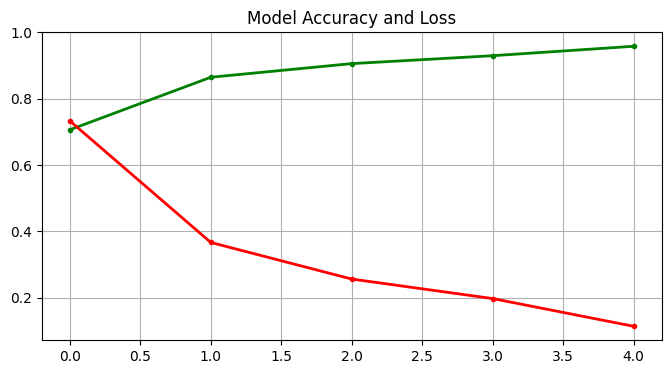

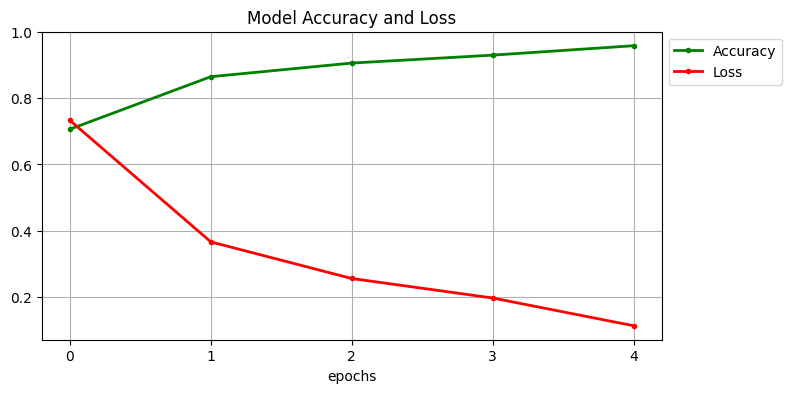

In [ ]:
plt.figure(figsize=(8, 4)) # figsize is a parameter, not a function
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Accuracy and Loss')
plt.figure(figsize=(8, 4)) # figsize is a parameter, not a function
plt.grid(True)
plt.plot(history.history['sparse_categorical_accuracy'], '.g-', linewidth = 2)
plt.plot(history.history['loss'], '.r-', linewidth = 2)
plt.title('Model Accuracy and Loss')
plt.xlabel('epochs')
plt.xticks([x for x in range(0, epochs)])
plt.legend(['Accuracy', 'Loss'], loc = 'upper left', bbox_to_anchor = (1, 1))
plt.show()

**MODEL CLASSIFICATION REPORT**

13/13 ━━━━━━━━━━━━━━━━━━━━ 85s 6s/step
classification report:
              precision    recall  f1-score   support

           0       0.98      0.68      0.80        74
           1       1.00      0.17      0.29       100
           2       0.61      0.98      0.76       115
           3       0.73      0.98      0.83       105

    accuracy                           0.72       394
   macro avg       0.83      0.70      0.67       394
weighted avg       0.81      0.72      0.67       394

Confusion Matrix:
[[ 50   0  12  12]
 [  1  17  57  25]
 [  0   0 113   2]
 [  0   0   2 103]]


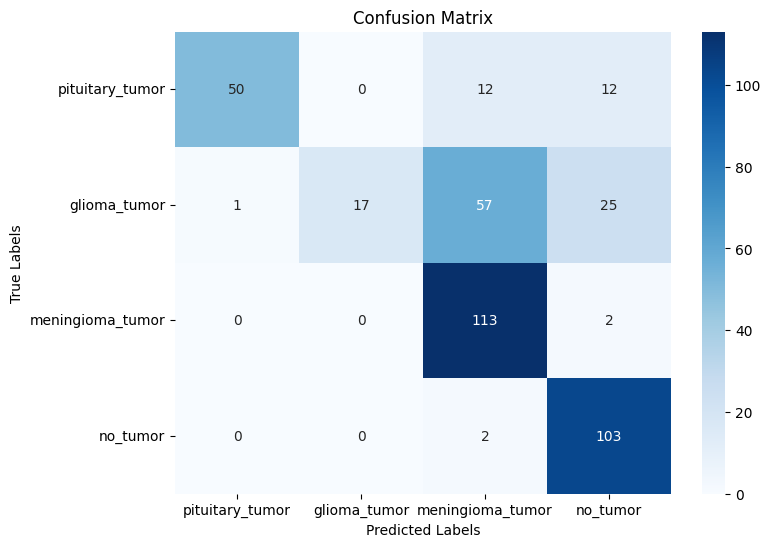

In [ ]:
import matplotlib.pyplot as plt # Import pyplot instead of the entire matplotlib module
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize
from tensorflow.keras.models import load_model
import numpy as np

# prediction on test data
test_images = open_images(test_paths)
test_labels_encoded = encode_labels(test_labels)

# predict using the trained model
test_predictions = model.predict(test_images)

# classsification report

print("classification report:")
print(classification_report(test_labels_encoded, test_predictions.argmax(axis = 1)))

 # Confusion Matrix

conf_matrix = confusion_matrix(test_labels_encoded,  np.argmax(test_predictions, axis = 1))# Confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

#plot the confusion matrix
plt.figure(figsize = (8, 6)) # Now this call would work as expected
sns.heatmap(conf_matrix, annot = True, fmt = 'd', cmap = 'Blues', xticklabels = os.listdir(train_dir), yticklabels = os.listdir(train_dir))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

**Roc Curve Plot**


<function matplotlib.pyplot.show(close=None, block=None)>

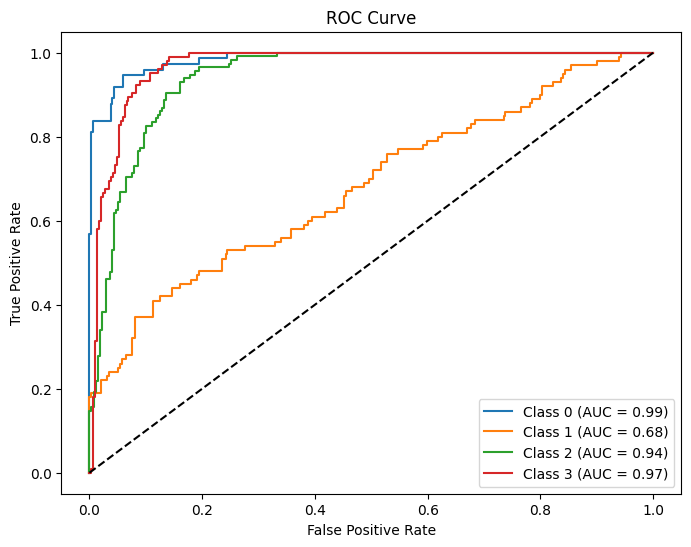

In [ ]:
# Roc cuve and AUC
# binarize the test labels and redictions for multi-class ROC
test_labels_bin = label_binarize(test_labels_encoded, classes = np.arange(len(os.listdir(train_dir))))
test_predictions_bin = test_predictions

#compute ROC curve and Roc Auc for each class
fpr, tpr, roc_auc = {}, {}, {}
for i in range(len(os.listdir(train_dir))):
  fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], test_predictions_bin[:, i])
  roc_auc[i] = auc(fpr[i], tpr[i])

#plot Roc Curve
plt.figure(figsize = (8, 6))
for i in range(len(os.listdir(train_dir))):
  plt.plot(fpr[i], tpr[i], label = f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc = 'lower right')
plt.show

Save the model


In [ ]:
model.save('model.h5')

In [ ]:
from tensorflow.keras.models import load_model
# load the trained model
loaded_model = load_model('model.h5') # Call load_model directly, assigning the result to a new variable

MRI Tumor Classififcation System

In [ ]:
from keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt


#class labels
class_labels = ['pituitary', 'glioma', 'notumor', 'meningioma']

def detect_and_display(img_path, model, image_size=(128, 128)):
    try:
        # Load and preprocessing images
        img = load_img(img_path, target_size=image_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # Make the prediction
        Predictions = model.predict(img_array)
        predicted_class_index = np.argmax(Predictions, axis=1)[0]

        # Get the maximum confidence score (as a single value)
        confidence_score = np.max(Predictions)  # Changed this line

        # Determine the class
        if class_labels[predicted_class_index] == 'notumor':
            result = 'Tumor Not Detected'
        else:
            result = f"Tumor: {class_labels[predicted_class_index]}"

        # Display the image with predictions
        plt.imshow(load_img(img_path))
        plt.axis('off')
        plt.title(f"{result} (Confidence: {confidence_score * 100:.2f}%)")
        plt.show()
    except Exception as e:
        print("Error processing image: ", str(e))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step


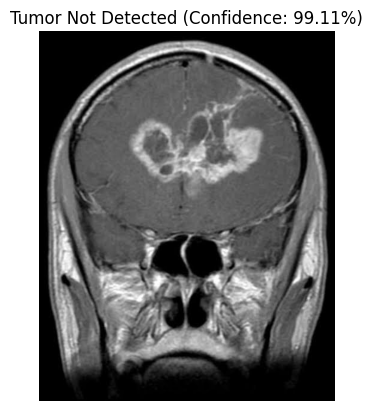

In [ ]:
image_path ='/content/drive/MyDrive/Testing/glioma_tumor/image(1).jpg'
detect_and_display(image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 704ms/step


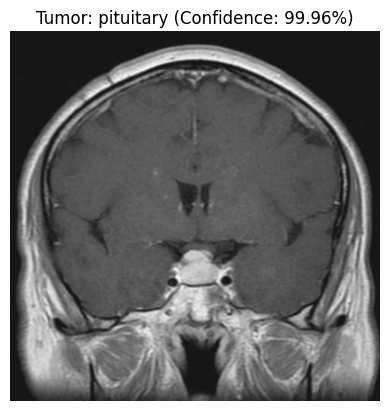

In [ ]:
image_path = '/content/drive/MyDrive/Testing/pituitary_tumor/image(10).jpg'
detect_and_display(image_path, model)